The goal of this script is to create site-level features to improve stratified split balance/reduce bias. The features created are gpp_mean_bins, gpp_var_bins, and hemisphere quadrant. 

# Notebook Setup

In [1]:
#TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
#MY_HOME_ABS_PATH = "/Users/jetcalz07/Desktop/MIDS/W210_Capstone/co2-flux-hourly-gpp-modeling"
MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling"

In [3]:
if 'google.colab' in str(get_ipython()):
  IN_COLLAB = True
  from google.colab import drive
  drive.mount('/content/drive/')
else:
  IN_COLLAB = False

## Import Modules

In [4]:
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
import pandas as pd
import numpy as np
import sys
import joblib
from io import BytesIO
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

# Load locale custome modules
os.chdir(MY_HOME_ABS_PATH)
if IN_COLLAB:
    sys.path.insert(0,os.path.abspath("./code/src/tools"))
else:
    sys.path.append(os.path.abspath("./code/src/tools"))

from CloudIO.AzStorageClient import AzStorageClient
from data_pipeline_lib import *

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [5]:
# Define constants
root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + '.tmp'
raw_data_dir = tmp_dir
data_dir = root_dir + os.sep + 'data'
cred_dir = root_dir + os.sep + '.cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'
preproc_objects_dir = root_dir + os.sep + 'code' + os.sep + 'src' + os.sep + 'preprocessing' + os.sep + 'preproc_objects'

# blob
container = "all-sites-data"
ext = "parquet"
ver = "mvp-v2-knn"
model = "rfr"
tag = "raw"
blob_name_base = f"{model}-full_2010_2015_v_{ver}"
blob_name = f"{blob_name_base}_{tag}.{ext}"

## Get Site Metadata and GPP Summaries

In [6]:
# Get the full set of sites that meet site criteria (130 sites)
load_data_checkpoint = True

if load_data_checkpoint:
    data_df = None
    local_file = tmp_dir + os.sep + blob_name 
    if not (os.path.exists(local_file)): 
        azStorageClient = AzStorageClient(az_cred_file)
        file_stream = azStorageClient.downloadBlob2Stream(container, blob_name)
        data_df = pd.read_parquet(file_stream, engine='pyarrow')
        data_df.to_parquet(local_file)
    else:
        data_df = pd.read_parquet(local_file)

    print(f"Data size: {data_df.shape}")
    good_sites = data_df['site_id'].unique()
    print(f"# of sites: {len(good_sites)}")

Data size: (4577688, 75)
# of sites: 128


In [9]:
# Load Site Metadata for good sites
site_metadata_filename = data_dir + os.sep + 'site-metadata.csv'
site_metadata_df_init = pd.read_csv(site_metadata_filename)
try:
    site_metadata_df_init.drop(columns=['site_hemisphere_quadrant', 'GPP_var', 'GPP_var_bins', 'GPP_mean', 'GPP_mean_bins'], inplace=True)
except:
    pass

site_metadata_df = site_metadata_df_init.loc[site_metadata_df_init['site_id'].isin(list(good_sites)), ].copy()
site_metadata_df.head(2)

,site_id,dataset,start_year,end_year,file,is_dup,IGBP,elevation,lat,long,site_name,koppen_sub,koppen_main,koppen_name,koppen_main_name,c3c4,c4_percent,filename,size,country,record_count,site_IGBP,site_koppen,start_time,end_time,recorded_day_count,recorded_day_percentage,monthly_data_available,hemisphere_NS,lat_band
0,AR-SLu,FLUXNET,2009,2011,FLX_AR-SLu_FLUXNET2015_FULLSET_MM_2009-2011_1-...,False,MF,NaN,-33.46480,-66.45980,San Luis,7,2,BSk,Arid,C3,67.08000,data_full_half_hourly_raw_v0_1_AR-SLu.csv,9785735.00000,AR,22128.00000,MF,Arid,2009-12-21 00:00:00,2011-03-26 23:30:00,461.00000,1.00000,Yes,South,lat_band_2
1,AR-Vir,FLUXNET,2009,2012,FLX_AR-Vir_FLUXNET2015_FULLSET_MM_2009-2012_1-...,False,ENF,NaN,-28.23950,-56.18860,Virasoro,14,3,Cfa,Temperate,C3,8.75000,data_full_half_hourly_raw_v0_1_AR-Vir.csv,14564015.00000,AR,33984.00000,ENF,Temperate,2010-02-13 00:00:00,2012-06-13 23:30:00,708.00000,0.83099,Yes,South,lat_band_2


In [10]:
def get_hemisphere_quadrant(lat, long):
    if lat >= 0 and long >= 0:
        return "North-East"
    elif lat >= 0 and long < 0:
        return "North-West"
    elif lat < 0 and long >= 0:
        return "South-East"
    elif lat < 0 and long < 0:
        return "South-West"

In [11]:
# Generate new site-level features
for i, r in site_metadata_df.iterrows():
    if not r.filename or type(r.filename) != type(""):
        print(f'SKIP: {r.site_id} is missing hourly data.')
        continue

    # Load site hourly data
    local_filename = tmp_dir + os.sep + r.filename
    site_df = pd.read_csv(local_filename, usecols = ['datetime', 'GPP_NT_VUT_REF'])
    
    # Get GPP mean and variance, save to meta df
    site_metadata_df.loc[i, 'GPP_mean'] = site_df['GPP_NT_VUT_REF'].mean()
    site_metadata_df.loc[i, 'GPP_var'] = site_df['GPP_NT_VUT_REF'].var()
    
    # Get hemisphere quadrant
    site_metadata_df.loc[i, 'site_hemisphere_quadrant'] = get_hemisphere_quadrant(r.lat, r.long)

In [12]:
# Create bins based on mean, var features to make categorical
bins = 128//5
site_metadata_df['GPP_mean_bins'] = pd.qcut(site_metadata_df['GPP_mean'], q=bins, labels=[f"gpp_mean_bin_{i}" for i in range(1, bins+1)])
site_metadata_df['GPP_var_bins'] = pd.qcut(site_metadata_df['GPP_var'], q=bins, labels=[f"gpp_var_bin_{i}" for i in range(1, bins+1)])

In [13]:
site_metadata_df.head(2)

,site_id,dataset,start_year,end_year,file,is_dup,IGBP,elevation,lat,long,site_name,koppen_sub,koppen_main,koppen_name,koppen_main_name,c3c4,c4_percent,filename,size,country,record_count,site_IGBP,site_koppen,start_time,end_time,recorded_day_count,recorded_day_percentage,monthly_data_available,hemisphere_NS,lat_band,GPP_mean,GPP_var,site_hemisphere_quadrant,GPP_mean_bins,GPP_var_bins
0,AR-SLu,FLUXNET,2009,2011,FLX_AR-SLu_FLUXNET2015_FULLSET_MM_2009-2011_1-...,False,MF,NaN,-33.46480,-66.45980,San Luis,7,2,BSk,Arid,C3,67.08000,data_full_half_hourly_raw_v0_1_AR-SLu.csv,9785735.00000,AR,22128.00000,MF,Arid,2009-12-21 00:00:00,2011-03-26 23:30:00,461.00000,1.00000,Yes,South,lat_band_2,6.89660,88.14843,South-West,gpp_mean_bin_25,gpp_var_bin_23
1,AR-Vir,FLUXNET,2009,2012,FLX_AR-Vir_FLUXNET2015_FULLSET_MM_2009-2012_1-...,False,ENF,NaN,-28.23950,-56.18860,Virasoro,14,3,Cfa,Temperate,C3,8.75000,data_full_half_hourly_raw_v0_1_AR-Vir.csv,14564015.00000,AR,33984.00000,ENF,Temperate,2010-02-13 00:00:00,2012-06-13 23:30:00,708.00000,0.83099,Yes,South,lat_band_2,10.67907,195.83335,South-West,gpp_mean_bin_25,gpp_var_bin_25


### Visualize

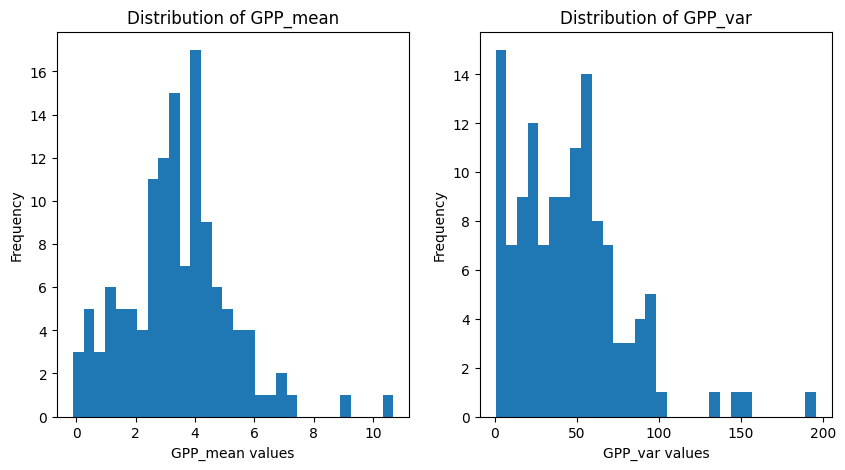

In [14]:
# Visualize GPP Mean, Var distributions
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(site_metadata_df.GPP_mean, bins=30)
ax[0].set_title('Distribution of GPP_mean')
ax[0].set_xlabel('GPP_mean values')
ax[0].set_ylabel('Frequency')

ax[1].hist(site_metadata_df.GPP_var, bins=30)
ax[1].set_title('Distribution of GPP_var')
ax[1].set_xlabel('GPP_var values')
ax[1].set_ylabel('Frequency')

plt.show()

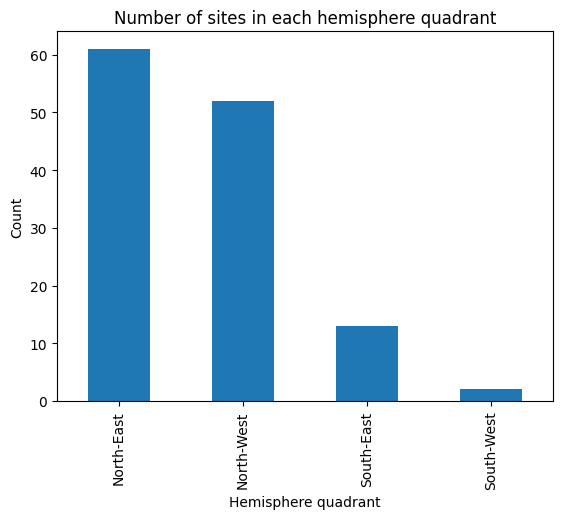

In [15]:
# See count of sites by hemisphere quadrant
# Group the DataFrame by hemisphere_quadrant and count the number of sites in each group
counts = site_metadata_df.groupby('site_hemisphere_quadrant')['site_id'].count()

# Plot the counts using a bar chart
counts.plot(kind='bar', legend=None)
plt.title('Number of sites in each hemisphere quadrant')
plt.xlabel('Hemisphere quadrant')
plt.ylabel('Count')
plt.show()

In [16]:
# Check distribution of bins
site_metadata_df.groupby('GPP_mean_bins')['site_id'].count()

GPP_mean_bins
gpp_mean_bin_1     6
gpp_mean_bin_2     5
gpp_mean_bin_3     5
gpp_mean_bin_4     5
gpp_mean_bin_5     5
gpp_mean_bin_6     5
gpp_mean_bin_7     5
gpp_mean_bin_8     5
gpp_mean_bin_9     5
gpp_mean_bin_10    5
gpp_mean_bin_11    5
gpp_mean_bin_12    5
gpp_mean_bin_13    6
gpp_mean_bin_14    5
gpp_mean_bin_15    5
gpp_mean_bin_16    5
gpp_mean_bin_17    5
gpp_mean_bin_18    5
gpp_mean_bin_19    5
gpp_mean_bin_20    5
gpp_mean_bin_21    5
gpp_mean_bin_22    5
gpp_mean_bin_23    5
gpp_mean_bin_24    5
gpp_mean_bin_25    6
Name: site_id, dtype: int64

## Save out

In [17]:
site_metadata_df_init.columns

Index(['site_id', 'dataset', 'start_year', 'end_year', 'file', 'is_dup',
       'IGBP', 'elevation', 'lat', 'long', 'site_name', 'koppen_sub',
       'koppen_main', 'koppen_name', 'koppen_main_name', 'c3c4', 'c4_percent',
       'filename', 'size', 'country', 'record_count', 'site_IGBP',
       'site_koppen', 'start_time', 'end_time', 'recorded_day_count',
       'recorded_day_percentage', 'monthly_data_available', 'hemisphere_NS',
       'lat_band'],
      dtype='object')

In [18]:
## Merge back into Site Meta Init, save out
print("merging new fetures in")
site_metadata_df_final = pd.merge(site_metadata_df_init, 
                                  site_metadata_df[['site_id', 'site_hemisphere_quadrant', 'GPP_var', 'GPP_var_bins', 'GPP_mean', 'GPP_mean_bins']],
                                  how='left', on='site_id')


print(len(site_metadata_df_final))
print(len(site_metadata_df_init))
site_metadata_df_final.head(2)

merging new fetures in
286
286


,site_id,dataset,start_year,end_year,file,is_dup,IGBP,elevation,lat,long,site_name,koppen_sub,koppen_main,koppen_name,koppen_main_name,c3c4,c4_percent,filename,size,country,record_count,site_IGBP,site_koppen,start_time,end_time,recorded_day_count,recorded_day_percentage,monthly_data_available,hemisphere_NS,lat_band,site_hemisphere_quadrant,GPP_var,GPP_var_bins,GPP_mean,GPP_mean_bins
0,AR-SLu,FLUXNET,2009,2011,FLX_AR-SLu_FLUXNET2015_FULLSET_MM_2009-2011_1-...,False,MF,NaN,-33.46480,-66.45980,San Luis,7,2,BSk,Arid,C3,67.08000,data_full_half_hourly_raw_v0_1_AR-SLu.csv,9785735.00000,AR,22128.00000,MF,Arid,2009-12-21 00:00:00,2011-03-26 23:30:00,461.00000,1.00000,Yes,South,lat_band_2,South-West,88.14843,gpp_var_bin_23,6.89660,gpp_mean_bin_25
1,AR-Vir,FLUXNET,2009,2012,FLX_AR-Vir_FLUXNET2015_FULLSET_MM_2009-2012_1-...,False,ENF,NaN,-28.23950,-56.18860,Virasoro,14,3,Cfa,Temperate,C3,8.75000,data_full_half_hourly_raw_v0_1_AR-Vir.csv,14564015.00000,AR,33984.00000,ENF,Temperate,2010-02-13 00:00:00,2012-06-13 23:30:00,708.00000,0.83099,Yes,South,lat_band_2,South-West,195.83335,gpp_var_bin_25,10.67907,gpp_mean_bin_25


In [19]:
site_metadata_df_final.to_csv(site_metadata_filename, index=False)